In [1]:
import pandas as pd
from pandas_gbq import read_gbq
import numpy as np
import os
import datetime
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from google.colab import auth
auth.authenticate_user()

client = bigquery.Client(project='freshly-case-study-468308')

query = "SELECT * FROM freshly_data.df_cleaned"
df = client.query(query).to_dataframe()


In [3]:
df.head()

,sku,albaran,unidades_vendidas,importe_sin_iva,clientenuevo_repetidor,ranking_pedido_DESC,gifting,BC_descripcion,activo_estudio,componente_pack,...,concern_18,concern_19,concern_20,concern_21,tipo_venta,BC_num_cliente,mercado,fecha_pedido,fecha_albaran,precio_unitario
0,M021176,ALV24-50695,1,10.50,Cliente Repetidor,1,False,Prod. PT Kids - Sweet Apple Body Cream - 200ml,ACT,True,...,False,False,True,False,Pedido Ecommerce,C1838050,ES,2024-01-22 17:13:13+00:00,2024-01-23,10.50
1,M020986,ALV24-461295,1,13.51,Cliente Repetidor,7,False,Prod. PT - Skin Rescue All-Purpose Balm - 40ml,ACT,False,...,False,False,True,False,Pedido Ecommerce,C0823603,ES,2024-06-16 11:15:11+00:00,2024-06-17,13.51
2,M021277,ALV24-524268,1,9.89,Cliente Nuevo,2,False,Prod. PT - Hyaluronic Lip Volumiser - 5ml,ACT,True,...,False,False,False,False,Pedido Ecommerce,C2012230,ES,2024-06-30 19:17:41+00:00,2024-07-02,9.89
3,M020853,ALV24-1008130,1,17.19,Cliente Repetidor,1,False,Prod. PT Makeup - Radiant Glow Primer Serum - ...,ACT,True,...,False,False,False,False,Pedido Ecommerce,C1336346,IT,2024-11-24 09:38:57+00:00,2024-11-28,17.19
4,M021341,ALV24-853103,1,33.71,Cliente Repetidor,1,False,Prod. PT - Genuine Firming Face Cream - 50ml,ACT,True,...,False,False,False,True,Pedido Ecommerce,C2000148,ES,2024-10-20 11:12:55+00:00,2024-10-21,33.71


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240516 entries, 0 to 3240515
Data columns (total 64 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   sku                       object             
 1   albaran                   object             
 2   unidades_vendidas         Int64              
 3   importe_sin_iva           float64            
 4   clientenuevo_repetidor    object             
 5   ranking_pedido_DESC       Int64              
 6   gifting                   boolean            
 7   BC_descripcion            object             
 8   activo_estudio            object             
 9   componente_pack           boolean            
 10  FF_CODE                   object             
 11  descripcion_familia       object             
 12  tipo_producto             object             
 13  pk_id_categoria           object             
 14  id_categoria              object             
 15  categoria      

In [5]:
freshly_color = (248/255, 217/255, 58/255)
freshly_color2 = (253/255, 247/255, 221/255)
freshly_orange = (230/255, 109/255, 57/255)

# Pregunta 1. Exploracion y conclusiones generales

Para la exploración y obtención de conclusiones generales sobre los datos proporcionados, he desarrollado y analizado distintos dashboards interactivos en Looker Studio [ver aqui](https://lookerstudio.google.com/reporting/4fbe94d7-af23-433c-aabf-25c1e019c676/page/74qTF).

A continuación, se presentan las principales conclusiones obtenidas a partir de este análisis.

## 1.1 SKU mas vendidos en 2024

In [6]:
df_no_gifting = df[df['gifting'] == False]

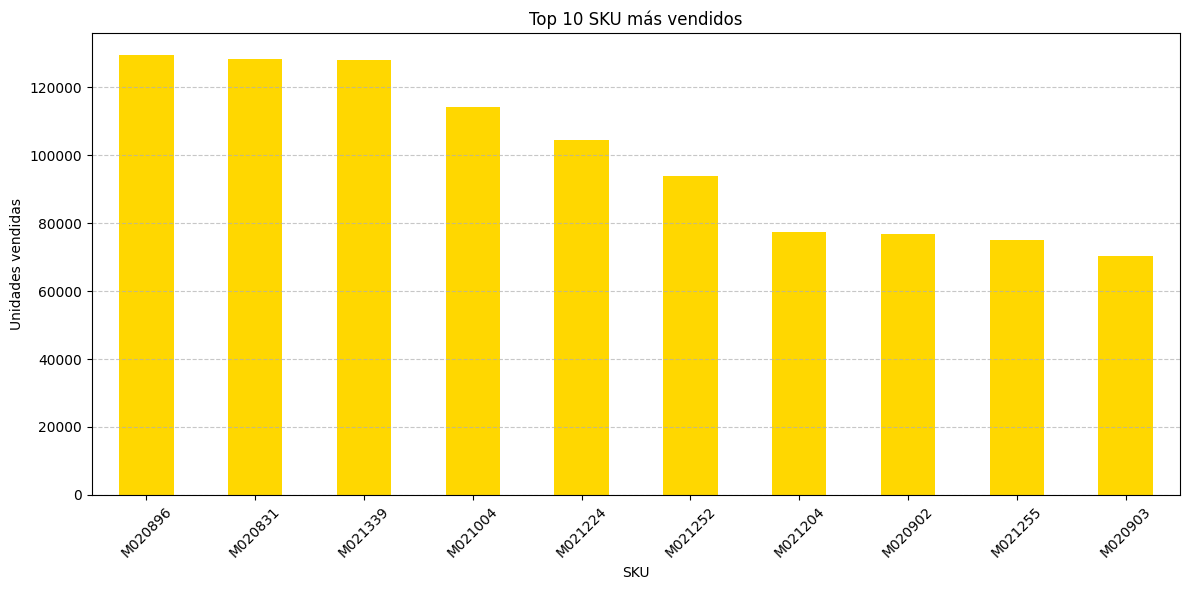

In [7]:
sku_ventas = df_no_gifting.groupby('sku')['unidades_vendidas'].sum()

top_skus = sku_ventas.sort_values(ascending=False).head(10)


plt.figure(figsize=(12,6))
top_skus.plot(kind='bar', color='gold')
plt.title('Top 10 SKU más vendidos')
plt.xlabel('SKU')
plt.ylabel('Unidades vendidas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
top_skus

,unidades_vendidas
sku,
M020896,129534
M020831,128410
M021339,128072
M021004,114238
M021224,104365
M021252,93965
M021204,77426
M020902,76796
M021255,75129


Los 10 productos más vendidos del año concentran gran parte de las ventas totales. Por ejemplo, el SKU M020896 lidera con 129,541 unidades vendidas, y muy cerca está el M020831 con 128,673 unidades. Esto muestra que la demanda está bastante concentrada en un pequeño grupo de productos clave.

In [9]:
top3_list = top_skus.head(3).index.tolist()
top3_categoria = df[(df['sku'].isin(top3_list))][['sku', 'categoria']].drop_duplicates()
top3_categoria

,sku,categoria
739387,M020831,Cuidado Corporal
1423139,M021339,Cuidado Corporal
2424007,M020896,Cuidado Facial


## 1.2 Categorias mas vendidas

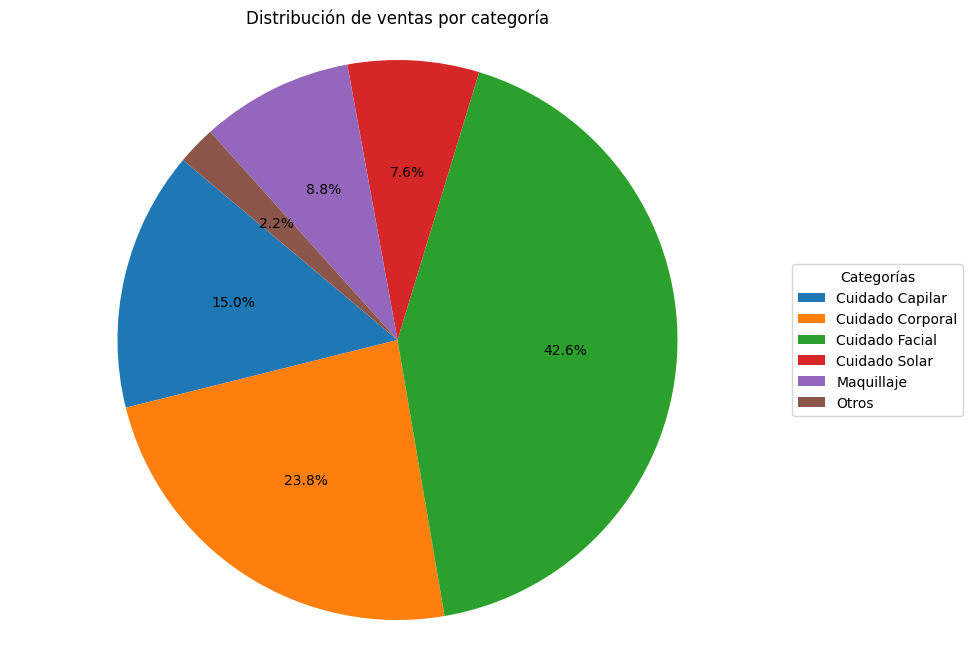

In [10]:
total_ventas = df_no_gifting['unidades_vendidas'].sum()
ventas_por_categoria = df_no_gifting.groupby('categoria')['unidades_vendidas'].sum()
porcentages_categoria = ventas_por_categoria / ventas_por_categoria.sum() * 100


mask = porcentages_categoria < 7
others_sum = porcentages_categoria[mask].sum()
porcentages_agrupados = porcentages_categoria[~mask]
porcentages_agrupados['Otros'] = others_sum


plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(porcentages_agrupados, autopct='%1.1f%%', startangle=140)


plt.legend(wedges, porcentages_agrupados.index,
           title="Categorías",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribución de ventas por categoría')
plt.axis('equal')
plt.show()

Las ventas están claramente dominadas por las categorías de cuidado personal. `Cuidado facial` representa el 42,6% del total, siendo la más importante. Le sigue `Cuidado corporal` con un 23,8%, y luego `Cuidado capilar` con un 15%. Las categorías de `Maquillaje` y `Cuidado solar` aportan un 8,8% y 7,6% respectivamente. Esto refleja las prioridades de los clientes y el foco principal de ventas en productos de cuidado de la piel y el cuerpo.

## 1.3 Facturación 2024

In [11]:
df_facturacion = df_no_gifting.copy()

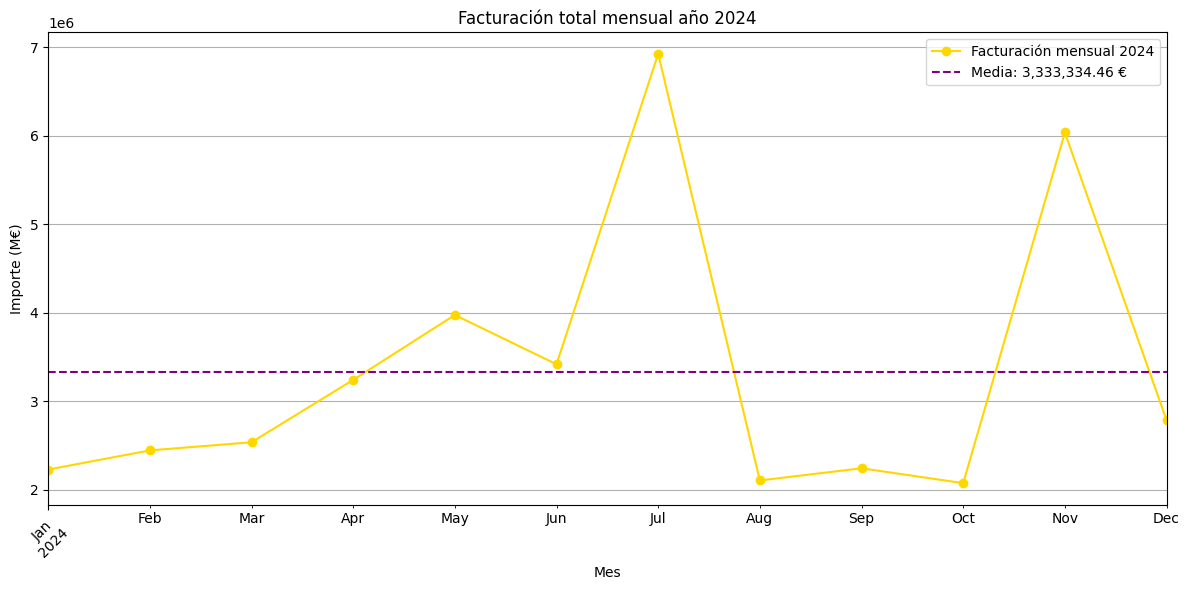

In [12]:
df_2024 = df_facturacion[df_facturacion['fecha_albaran'].dt.year == 2024].copy()


df_2024['importe_total'] = df_2024['precio_unitario'] * df_2024['unidades_vendidas']
df_2024['mes'] = df_2024['fecha_albaran'].dt.to_period('M')


facturacion_mensual = df_2024.groupby('mes')['importe_total'].sum()
media_facturacion = facturacion_mensual.mean()


plt.figure(figsize=(12,6))
facturacion_mensual.plot(kind='line', marker='o', label='Facturación mensual 2024', color='gold')
plt.axhline(media_facturacion, color='purple', linestyle='--', label=f'Media: {media_facturacion:,.2f} €')

plt.title('Facturación total mensual año 2024')
plt.xlabel('Mes')
plt.ylabel('Importe (M€)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observamos picos significativos en los meses de `Julio` y `Noviembre`. Vamos a investigar a qué se deben; podría estar relacionado con alguna campaña publicitaria o colaboración.

## 1.4 Relación facturación con colaboraciones

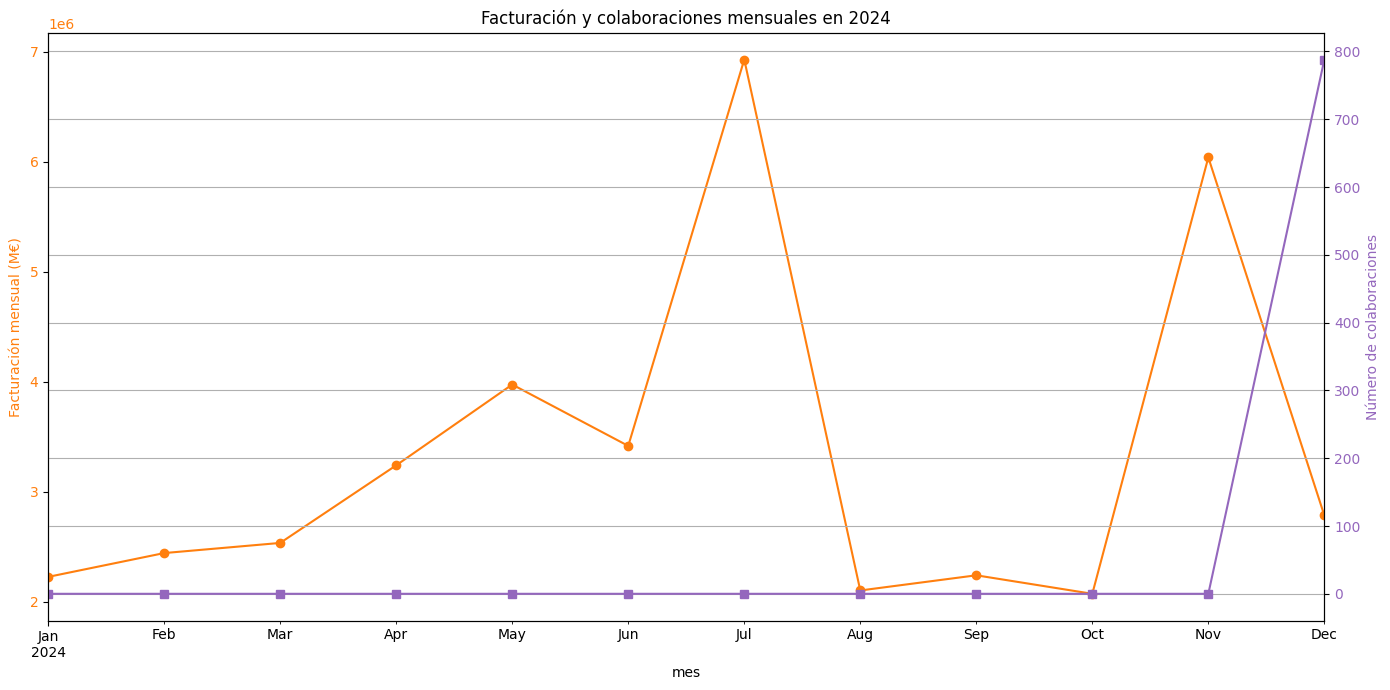

In [13]:
colaboraciones_mensual = df_2024.groupby('mes')['colaboracion'].sum()


fig, ax1 = plt.subplots(figsize=(14,7))

color = 'tab:orange'
ax1.set_xlabel('Mes')
ax1.set_ylabel('Facturación mensual (M€)', color=color)
facturacion_mensual.plot(kind='line', marker='o', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Número de colaboraciones', color=color)
colaboraciones_mensual.plot(kind='line', marker='s', ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Facturación y colaboraciones mensuales en 2024')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las colaboraciones que se han hecho no tienen un impacto sobre el numero de ventas

## 1.5 Productos mas vendidos en Julio

Vamos a analizar cuáles fueron los productos más vendidos en `Julio` para entender las posibles causas del aumento significativo en las ventas durante ese mes.



In [14]:
df_julio = df_no_gifting[
    (df_no_gifting['fecha_albaran'].dt.month == 7) &
    (df_no_gifting['fecha_albaran'].dt.year == 2024)
]

ventas_julio = df_julio.groupby('sku')['unidades_vendidas'].sum().sort_values(ascending=False)
ventas_julio_df = ventas_julio.head(10).reset_index()
ventas_julio_df.columns = ['sku', 'unidades_vendidas']

print(ventas_julio_df)

       sku  unidades_vendidas
0  M021004              32077
1  M020831              32019
2  M021224              26500
3  M021339              21962
4  M021255              19746
5  M020896              19486
6  M020907              17266
7  M021252              15537
8  M020833              12661
9  M020832              12164


In [15]:
ventas_julio_df = ventas_julio.head(10).reset_index()
ventas_julio_df.columns = ['sku', 'unidades_vendidas']

tabla_julio = ventas_julio_df.merge(
    df[['sku', 'categoria', 'descripcion_familia', 'BC_descripcion']].drop_duplicates(subset=['sku']),
    on='sku',
    how='left'
)

print(tabla_julio)

       sku  unidades_vendidas         categoria  \
0  M021004              32077     Cuidado Solar   
1  M020831              32019  Cuidado Corporal   
2  M021224              26500   Cuidado Capilar   
3  M021339              21962  Cuidado Corporal   
4  M021255              19746  Cuidado Corporal   
5  M020896              19486    Cuidado Facial   
6  M020907              17266  Cuidado Corporal   
7  M021252              15537    Cuidado Facial   
8  M020833              12661  Cuidado Corporal   
9  M020832              12164  Cuidado Corporal   

               descripcion_familia  \
0              BRONCEADOR CORPORAL   
1       BODY OIL - GOLDEN RADIANCE   
2                          KERATIN   
3  DESODORANTE - CARING MICROBIOME   
4                      BETA BURNER   
5                        VITAMIN C   
6                       HYALURONIC   
7    CONCENTRATE EYE CONTOUR SERUM   
8                  BODY OIL - GLOW   
9       BODY OIL - GOLDEN RADIANCE   

                   

Observamos que una gran parte de los productos más vendidos en `Julio` están relacionados con el `Cuidado solar` y el `Cuidado corporal`. Esto tiene sentido, dado que en Julio el consumo de protectores solares suele aumentar considerablemente. En particular, el producto M021004 ha sido un éxito destacado durante este mes.

Curiosamente, el `7,6%` del total anual de ventas de productos de `Cuidado solar`d se concentra únicamente en el mes de `Julio`, lo que evidencia la fuerte estacionalidad de esta categoría.

## 1.6 Productos mas vendidos en Noviembre

In [16]:
df_noviembre = df_no_gifting[
    (df_no_gifting['fecha_albaran'].dt.month == 11) &
    (df_no_gifting['fecha_albaran'].dt.year == 2024)
]

ventas_noviembre = df_noviembre.groupby('sku')['unidades_vendidas'].sum().sort_values(ascending=False)
ventas_noviembre_df = ventas_noviembre.head(10).reset_index()
ventas_noviembre_df.columns = ['sku', 'unidades_vendidas']

tabla_noviembre = ventas_noviembre_df.merge(
    df[['sku', 'categoria', 'descripcion_familia', 'BC_descripcion']].drop_duplicates(subset=['sku']),
    on='sku',
    how='left'
)

print(tabla_noviembre)

       sku  unidades_vendidas         categoria  \
0  M020896              31840    Cuidado Facial   
1  M021224              22292   Cuidado Capilar   
2  M021339              21255  Cuidado Corporal   
3  M021252              20728    Cuidado Facial   
4  M021204              18478   Cuidado Capilar   
5  M021447              15229    Cuidado Facial   
6  M020831              15193  Cuidado Corporal   
7  M021257              14741    Cuidado Facial   
8  M020902              14700    Cuidado Facial   
9  M020903              14012    Cuidado Facial   

               descripcion_familia  \
0                        VITAMIN C   
1                          KERATIN   
2  DESODORANTE - CARING MICROBIOME   
3    CONCENTRATE EYE CONTOUR SERUM   
4                      HAIR GROWTH   
5                       HYDRA MILK   
6       BODY OIL - GOLDEN RADIANCE   
7                      OMEGA CREMA   
8                     AZELAIC FACE   
9                      ROSE QUARTZ   

                   

En `Noviembre` se vendió mucho `Vitamina C` para la cara, probablemente porque la gente empieza a cuidar más la piel antes del invierno. También puede que hayan hecho promociones o que sea por la reparación tras el verano. Además, con las fiestas cerca, mucha gente se preocupa más por su piel.

## 1.7 Ventas individuales y en pack

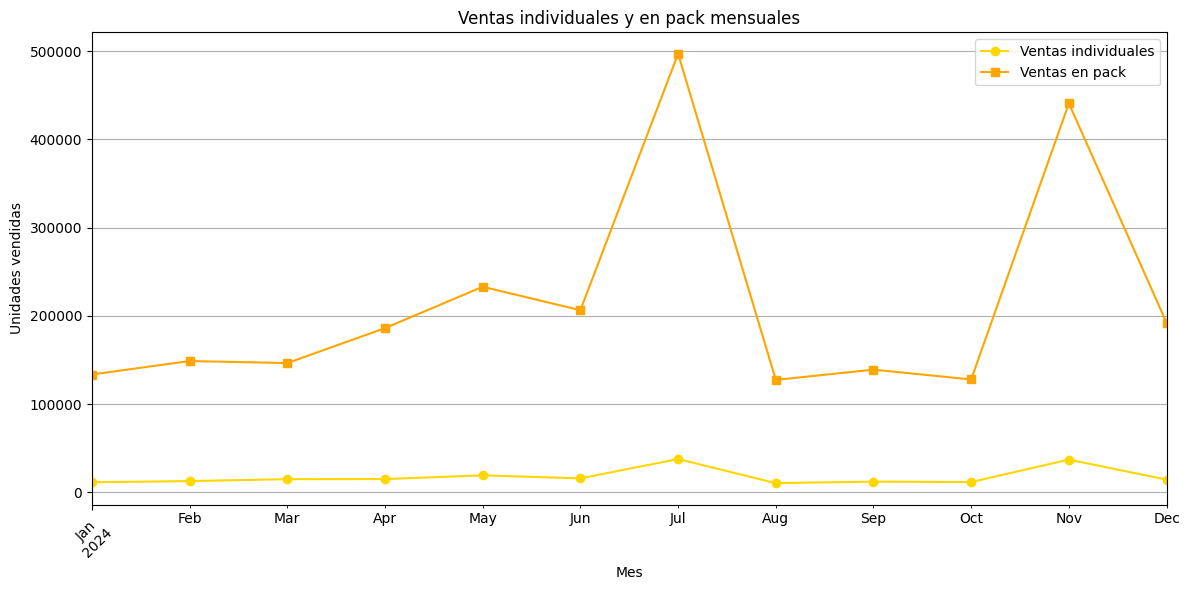

In [17]:
ventas_individuales = df_2024[df_2024['componente_pack'] == False].groupby('mes')['unidades_vendidas'].sum()


ventas_pack = df_2024[df_2024['componente_pack'] == True].groupby('mes')['unidades_vendidas'].sum()


plt.figure(figsize=(12,6))
ventas_individuales.plot(kind='line', marker='o', label='Ventas individuales', color='gold')
ventas_pack.plot(kind='line', marker='s', label='Ventas en pack', color='orange')

plt.title('Ventas individuales y en pack mensuales')
plt.xlabel('Mes')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El análisis mensual muestra que claramente se venden más unidades de productos en pack que unidades individuales. Esta tendencia indica que los clientes prefieren adquirir los productos agrupados, posiblemente debido a ofertas, conveniencia o estrategias comerciales que incentivan la compra en formato pack.

# Pregunta 2 Análisis de cohortes producto M020831

Realiza un análisis de cohortes de repetición por producto del sku `M020831`, contenido en la familia de productos `FF-023`, para el canal de venta `Ecommerce`. Extrae conclusiones.

In [18]:
# 1. Filtrar el dataset
df_cohorte = df_no_gifting[
    (df_no_gifting['sku'] == 'M020831') &
    (df_no_gifting['FF_CODE'] == 'FF-023') &
    (df_no_gifting['tipo_venta'] == 'Pedido Ecommerce')
].copy()

# Convertir fechas a periodo mensual per simplificar l'anàlisi
df_cohorte['fecha_albaran_mes'] = df_cohorte['fecha_albaran'].dt.to_period('M')

# 2. Identificar la cohorte inicial: mes de la primera compra per client
primer_pedido = df_cohorte.groupby('BC_num_cliente')['fecha_albaran_mes'].min().reset_index()
primer_pedido.columns = ['BC_num_cliente', 'cohorte_mes']

# 3. Unir la cohorte al dataframe original
df_cohorte = df_cohorte.merge(primer_pedido, on='BC_num_cliente')

# 4. Calcular diferencia de mesos entre compra i cohorte inicial
df_cohorte['meses_desde_cohorte'] = (df_cohorte['fecha_albaran_mes'] - df_cohorte['cohorte_mes']).apply(lambda x: x.n)

# 5. Calcular número de clients únics per cohorte i mes des de la compra inicial (repetición)
cohorte_pivot = df_cohorte.groupby(['cohorte_mes', 'meses_desde_cohorte'])['BC_num_cliente'] \
    .nunique().reset_index()

# 6. Transformar a tabla de cohorts (pivot)
tabla_cohorte = cohorte_pivot.pivot(index='cohorte_mes', columns='meses_desde_cohorte', values='BC_num_cliente')

# 7. Opcional: calcular tasa de retención (dividir per el nombre de clients de la cohorte inicial)
cohorte_size = tabla_cohorte[0]
tabla_cohorte_tasa = tabla_cohorte.divide(cohorte_size, axis=0)

print(tabla_cohorte_tasa)

meses_desde_cohorte   0         1         2         3         4         5   \
cohorte_mes                                                                  
2024-01              1.0  0.021458  0.033406  0.034138  0.034870  0.025604   
2024-02              1.0  0.022319  0.032589  0.036342  0.028442  0.061031   
2024-03              1.0  0.018647  0.033003  0.026073  0.050000  0.013696   
2024-04              1.0  0.020410  0.020637  0.052047  0.011453  0.011226   
2024-05              1.0  0.015491  0.050129  0.013124  0.011080  0.007207   
2024-06              1.0  0.034850  0.012469  0.011510  0.008100  0.024939   
2024-07              1.0  0.007888  0.007772  0.005414  0.021538  0.008082   
2024-08              1.0  0.012596  0.009053  0.024011  0.010628  0.000394   
2024-09              1.0  0.009786  0.038553  0.014531       NaN       NaN   
2024-10              1.0  0.050067  0.019222       NaN       NaN       NaN   
2024-11              1.0  0.007879  0.000097       NaN       NaN

/tmp/ipython-input-19-1847604236.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(tabla_log, annot=tabla_cohorte_tasa.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else ""),


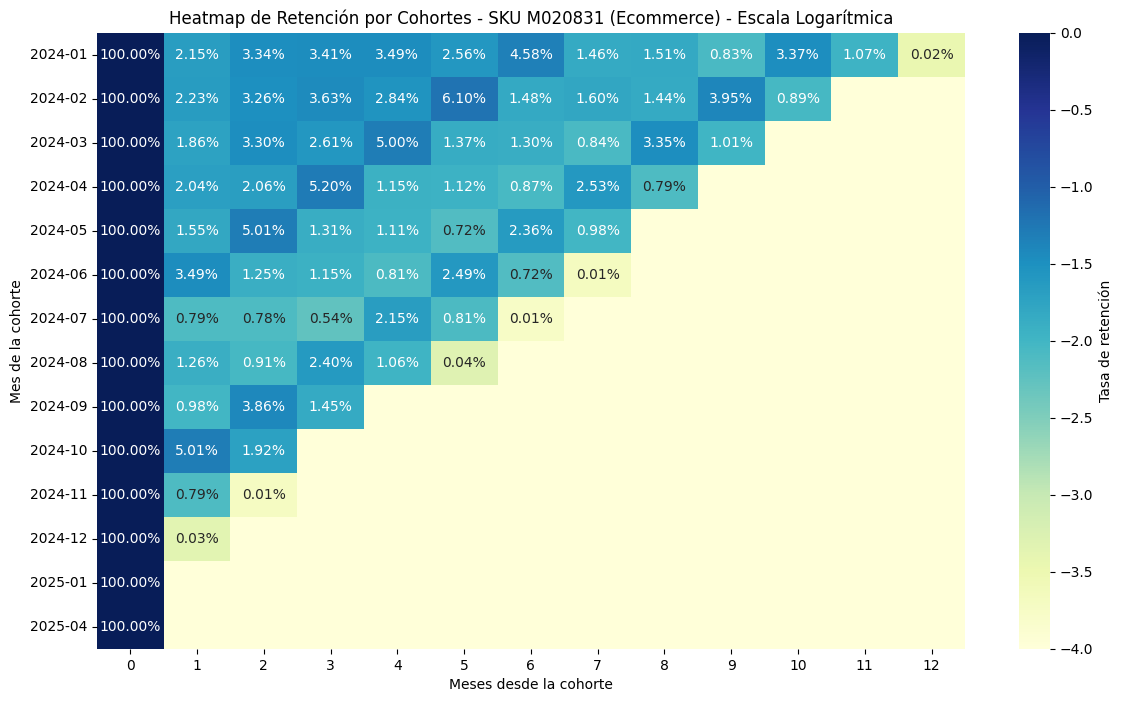

In [19]:
# Visualizamos los resultados
epsilon = 1e-4
tabla_log = np.log10(tabla_cohorte_tasa.fillna(0) + epsilon)

plt.figure(figsize=(14, 8))
sns.heatmap(tabla_log, annot=tabla_cohorte_tasa.applymap(lambda x: f"{x:.2%}" if pd.notna(x) else ""),
            fmt="", cmap="YlGnBu", cbar_kws={'label': 'Tasa de retención'})
plt.title("Heatmap de Retención por Cohortes - SKU M020831 (Ecommerce) - Escala Logarítmica")
plt.xlabel("Meses desde la cohorte")
plt.ylabel("Mes de la cohorte")
plt.show()

**Interpretación general:**

El eje vertical muestra el mes en que los clientes hicieron su primera compra del producto (cohorte), y el eje horizontal indica los meses transcurridos desde esa compra inicial. Los valores en cada celda representan el porcentaje de clientes que repiten compra en ese mes, y los colores reflejan la tasa de retención en escala logarítmica.

**Observaciones clave:**

La retención es del 100% en el mes 0, ya que son los clientes que compraron por primera vez. Sin embargo, esta tasa cae rápidamente en los meses siguientes, situándose entre un 1% y 5% después del primer mes y disminuyendo aún más con el tiempo. Algunas cohortes muestran ligeras subidas, pero en general la tendencia es a la baja.

**Conclusiones:**

La mayoría de los clientes que compran el SKU M020831 no vuelven a comprarlo pasado el primer mes, lo que indica una baja frecuencia de recompra o poco engagement. Probablemente es un producto de compra puntual o con un largo periodo entre compras. Sería interesante explorar acciones para fomentar la repetición, como promociones o nuevos formatos. También convendría comparar esta retención con otros productos de la misma familia para entender si es un patrón general o específico.

## 2.1 Inspección producto

Primero vamos a ver en detalle de que producto se trata

In [20]:
df_producto = df_no_gifting[df_no_gifting['sku'] == 'M020831']

info_producto = df_producto[['sku', 'categoria', 'descripcion_familia', 'BC_descripcion']].drop_duplicates()

print(info_producto)

            sku         categoria         descripcion_familia  \
739387  M020831  Cuidado Corporal  BODY OIL - GOLDEN RADIANCE   

                                     BC_descripcion  
739387  Prod. PT - Golden Radiance Body Oil - 100ml  


Vemos que se trata de un `Aceite corporal` en formato de `100 ml`, por lo que su consumo no es rápido, ya que se utiliza poca cantidad en cada aplicación. De todas formas, vamos a comprobar si se vende menos que otros productos de la misma familia `FF-023`.

In [21]:
productos_familia = df_no_gifting[df_no_gifting['FF_CODE'] == 'FF-023']

ventas_familia = productos_familia.groupby('sku')['unidades_vendidas'].sum().sort_values(ascending=False)

print(ventas_familia.head(10))

sku
M020831    128410
M020832     52747
M021150     18276
M021156      8112
M021199        42
M021450        13
Name: unidades_vendidas, dtype: Int64


**Tras verificar las ventas de los productos de la misma familia, este aceite corporal de 100 ml resulta ser el producto estrella. Por lo tanto, la baja frecuencia de recompra probablemente se deba a su formato de 100 ml y al poco producto que se utiliza en cada aplicación.**

# Pregunta 3 Propuesta equipo Marketing

**Principales preocupaciones de los clientes**

Vamos a echar un vistazo a las preocupaciones que tienen los clientes cuando compran, usando las columnas de `concern_00` a `concern_21`. La idea es ver cuáles son las `preocupaciones más comunes` y cómo influyen en las ventas.

Para eso, vamos a calcular dos cosas:
1.	Cuántos clientes tienen cada preocupación.
2.	Cuántas unidades compran de media esos clientes según la preocupación que tengan.

Con esto queremos entender no solo qué preocupa más a la gente, sino también qué preocupaciones están relacionadas con un mayor volumen de compra. Así, marketing y producto podrán centrarse en lo que realmente importa para los clientes y para el negocio.

Principales preocupaciones de los clientes:
concern_07    828106
concern_06    631543
concern_04    495610
concern_01    459116
concern_17    376794
concern_05    339927
concern_02    334301
concern_00    261112
concern_13    239504
concern_15    214565
dtype: Int64


/tmp/ipython-input-24-492737961.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=concern_counts.head(10).index, y=concern_counts.head(10).values, palette='pastel')


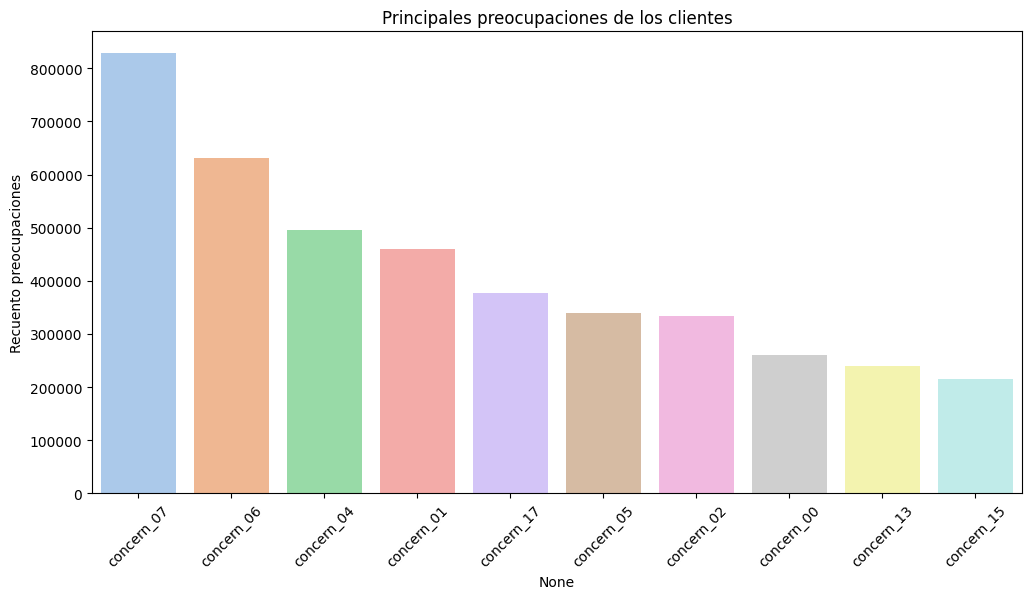


 Mediana de ventas por cliente segun preocupación:
concern_21     93.88623
concern_20    34.670033
concern_18    16.414153
concern_19     14.78854
concern_11    14.231986
concern_03     14.22234
concern_08    14.164097
concern_10    13.994577
concern_00    11.102339
concern_16    10.884937
dtype: object


/tmp/ipython-input-24-492737961.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=concern_impact_df.head(10).index, y=concern_impact_df.head(10).values, palette='magma')


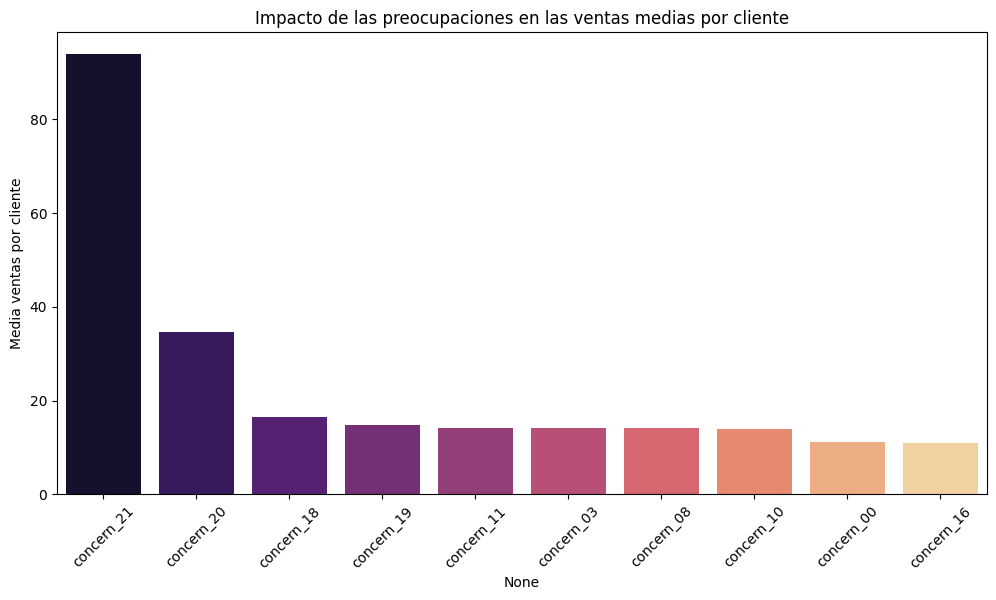

In [24]:
concern_cols = [col for col in df_no_gifting.columns if col.startswith('concern_')]

# Contamos las preocupaciones
concern_counts = df_no_gifting[concern_cols].sum().sort_values(ascending=False)

# Mostramos las principales preocupaciones
print("Principales preocupaciones de los clientes:")
print(concern_counts.head(10))

# Visualizamos con un grafico de barras
plt.figure(figsize=(12,6))
sns.barplot(x=concern_counts.head(10).index, y=concern_counts.head(10).values, palette='pastel')
plt.xticks(rotation=45)
plt.ylabel('Recuento preocupaciones')
plt.title('Principales preocupaciones de los clientes')
plt.show()

# Calculamos la media de ventas por cliente y preocupaciones

# Creamos un dataframe con las ventas por cliente
ventas_cliente = df_no_gifting.groupby('BC_num_cliente')['unidades_vendidas'].sum()

# Añadimos nueva columna con la media de ventas por preocupacion
concern_impact = {}
for concern in concern_cols:
    clients_with_concern = df_no_gifting[df_no_gifting[concern]==True]['BC_num_cliente'].unique()
    avg_sales = ventas_cliente.loc[ventas_cliente.index.isin(clients_with_concern)].mean()
    concern_impact[concern] = avg_sales

concern_impact_df = pd.Series(concern_impact).sort_values(ascending=False)

# Mostramos el impacto en las ventas de las principales preocupaciones
print("\n Mediana de ventas por cliente segun preocupación:")
print(concern_impact_df.head(10))

# Visualizamos
plt.figure(figsize=(12,6))
sns.barplot(x=concern_impact_df.head(10).index, y=concern_impact_df.head(10).values, palette='magma')
plt.xticks(rotation=45)
plt.ylabel('Media ventas por cliente')
plt.title('Impacto de las preocupaciones en las ventas medias por cliente')
plt.show()

Del análisis de las preocupaciones de los clientes, podemos sacar algunas conclusiones importantes:
-	Las preocupaciones que más aparecen son las `concern_07`, `concern_06` y `concern_04`
, que afectan a muchísima gente. Esto quiere decir que para producto y marketing son temas clave porque reflejan lo que más les preocupa a la mayoría.
-	Por otro lado, hay preocupaciones que no son tan comunes, como `concern_21` y `concern_20`, que afectan a menos clientes, pero esos clientes compran bastante más de media. Esto nos dice que aunque sean grupos pequeños, son súper valiosos desde el punto de vista de ventas.

Es decir, no siempre lo que preocupa a más gente es lo que genera más ingresos. Por eso es importante no solo mirar el volumen, sino también el potencial comercial.
Mi recomendación es que el equipo de marketing y producto profundice en cada una de estas preocupaciones para entender bien qué hay detrás de ellas. Esto permitiría diseñar campañas más personalizadas, que hablen directamente a las necesidades y dudas de cada segmento de clientes.

Por ejemplo, para las preocupaciones más comunes que afectan a un gran número de clientes, se podrían crear contenidos, promociones o mejoras en el producto que resuelvan esos puntos de forma clara y directa. Mientras que para las preocupaciones que afectan a menos personas pero que están relacionadas con clientes que compran más, se podrían preparar estrategias más específicas, como ofertas exclusivas o bundles, para potenciar aún más esa relación y maximizar las ventas.

En cuanto al producto, esta información puede ayudar a ajustar características, ingredientes, formatos o modos de uso para que respondan mejor a esas preocupaciones concretas, aumentando la satisfacción del cliente. Y clientes satisfechos son más propensos a repetir compra y a recomendar la marca.

En definitiva, personalizar la comunicación y el desarrollo de producto basándose en estas preocupaciones es clave para fidelizar a los clientes que más valor aportan y para atraer a nuevos clientes.

# Pregunta 4 KPI relevantes

### ¿Cuáles crees que son los KPI más relevantes para descubrir el crecimiento saludable de Freshly Cosmetics en un mercado?

Para mí, los KPIs más importantes para ver si Freshly está creciendo bien en un mercado son:
-	Cuánto se vende, tanto online, en tiendas físicas y B2B, para saber dónde está funcionando mejor.
-	Cuántos clientes nuevos conseguimos y cuántos vuelven a comprar, eso te dice si estás fidelizando o solo vendiendo una vez.
-	La frecuencia con la que repiten compra, porque si la gente no vuelve, algo falla o el producto es de uso muy puntual.
-	Saber en qué zonas o ciudades vendemos más, para poder centrar campañas o abrir tiendas donde realmente interesa.
-	Y también tener en cuenta la opinión de los clientes, para ir mejorando lo que ofrecemos.

### ¿Cómo monitorizamos estos indicadores? De ser el caso, ¿qué datos te faltarían para poder conseguir esta monitorización?

Para monitorizar estos KPIs, ya contamos con datos consolidados de ventas tanto online como offline, organizados por fecha, producto y cliente, lo que permite hacer análisis y ver tendencias con herramientas como Looker Studio.

Lo que echo en falta para hacerlo mejor es disponer de datos más específicos sobre la ubicación de los clientes, como su código postal, para entender mejor el mercado local y poder diseñar campañas más efectivas o plantear aperturas de tiendas físicas en las zonas con mayor potencial. También sería útil tener más información para segmentar mejor a los clientes.

Además, disponer de datos detallados sobre las campañas de marketing ayudaría a evaluar su efectividad y ajustar la inversión de forma más precisa. En gráficos anteriores de este notebook se ha visto que hay pocas colaboraciones, por lo que no se puede apreciar bien su impacto real en las ventas.


# Pregunta 5 Error en tabla

Supongamos que el equipo ha detectado un error en una tabla donde se visualizan datos de ventas procesados por el equipo de Data.

### ¿Qué preguntas harías al miembro del equipo que ha detectado el error? Solo sabes que hay un error, pero no tienes más información.

- Qué tipo de error has detectado? Són datos incorrectos? Faltantes? Duplicados? Incosistencias?
- En que tabla o gráfico has detectado el error?
- Desde cuando sospechas que existe el error?
- Afecta a todos los datos o solo unas fechas especificas?
- Ha habido un cambio reciente en el pipeline o en la base de datos?

### ¿Qué pasos seguirías para investigar y corregir el error? Describe brevemente tu enfoque.

Seguiria los siguientes pasos:
- Revisar los posibles casos aportados por el compañero/a para entender la naturaleza del error.
- Comparar con una backup o una versión anterior que funcionara correctamente para detectar donde está el error.
- Validar el origen de los datos, comparando la tabla o gráfico con las fuentes originales para detectar inconsistencias o algun problema.
- Comprobar el pipeline de procesamiento, analizando paso a paso donde se transforman o agregan datos para detectar possibles fallos.

Si, tras realizar estas comprobaciones no identifico el origen del error, consultaría con el equipo de data para analizar las posibles soluciones y definir juntos el plan de acción más adecuado.

# Pregunta 6. Responsabilidad en Freshly

### ¿Cuál consideras es la principal responsabilidad del Data Analyst en el Freshly Team?, y ¿qué valor podrías aportar tú personalmente a Freshly Cosmetics como Data Analyst?

La responsabilidad principal como Data Analyst en Freshly es transformar los datos recopilados en información útil para los demás departamentos y así poder apoyar la toma de decisiones estratégicas. Esto implica limpiar, analizar y visualizar los datos, identificar tendencias y patrones, y comunicar los insights de forma clara a los compañeros mediante dashboards interactivos y que se actualicen periodicamente que puedan usar y con los que puedan trabajar fácilmente.

Creo que puedo aportar una combinación de rigor analítico y enfoque práctico. Me gusta entender no solo qué dicen los datos sinó también el contexto del negocio para que los insights tengan un impacto real.
Además me esfuerzo para comunicar los resultados de forma sencilla y visual, facilitando así que los equipos no técnicos puedan entender y usar la informacion para mejorar sus acciones y resultados.
También aporto muchas ganas de aprender, colaborar y adaptarme rápido para ayudar a Freshly a crecer.